In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import yfinance as yf
from scipy.stats import gmean

# add utils path
src_path = os.path.abspath('../../')
if src_path not in sys.path:
    sys.path.append(src_path)

# import custom functions
from src.backtest import BacktestTrader
from src.strategies import EWMAC
from src.utils import get_risk_free_rate

In [2]:
START_DATE = '1999-01-21'
END_DATE = datetime.today().strftime('%Y-%m-%d')
TICKER = 'SPY'

SHORT_WINDOW = 16
LONG_WINDOW = 64

prices = yf.download(TICKER, start=START_DATE, end=END_DATE)['Adj Close']
risk_free_rate = get_risk_free_rate(START_DATE, END_DATE)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


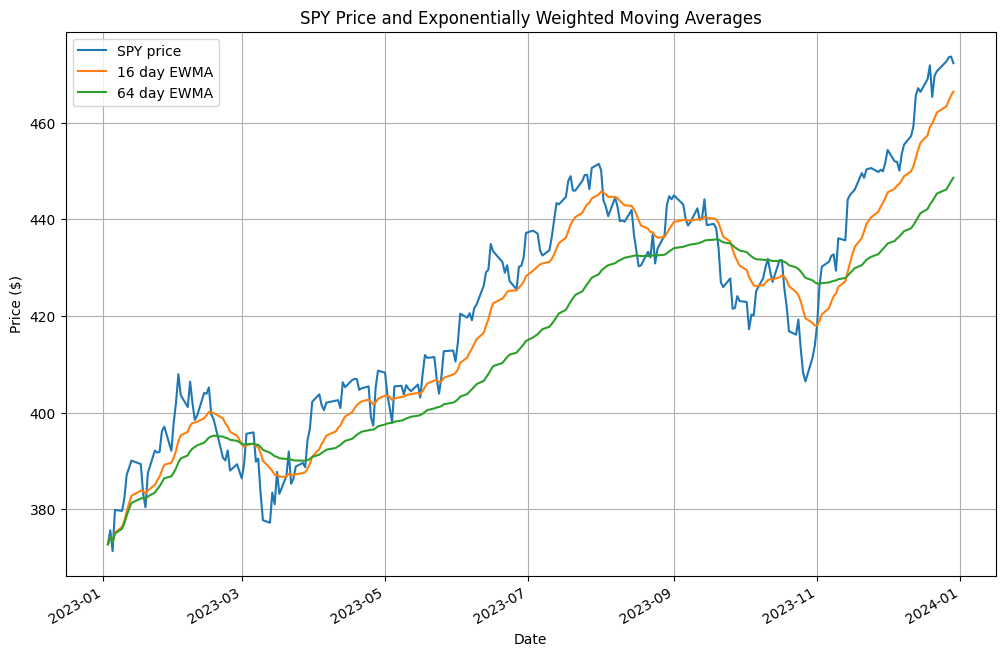

In [3]:
# example of EWMA crossover strategy
ex_data = yf.download(TICKER, start='2023-01-01', end='2023-12-31')['Adj Close']

plt.figure(figsize=(12, 8))
plt.plot(ex_data, label=f'{TICKER} price')
ex_data.ewm(span=SHORT_WINDOW).mean().plot(label=f'{SHORT_WINDOW} day EWMA')
ex_data.ewm(span=LONG_WINDOW).mean().plot(label=f'{LONG_WINDOW} day EWMA')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{TICKER} Price and Exponentially Weighted Moving Averages')
plt.legend()
plt.grid()
plt.show()

In [4]:
stock_returns = prices.pct_change().dropna()
total_returns = (prices.iloc[-1]-prices.iloc[0])/prices.iloc[0]
average_returns = gmean(np.array(stock_returns)+1)-1
annual_returns = (1+average_returns)**252 - 1
annual_std = np.std(stock_returns) * np.sqrt(252)
sharpe_ratio = (annual_returns - risk_free_rate.mean()) / annual_std

stock_results = {
    'total_returns': total_returns,
    'average_returns': average_returns,
    'annual_returns': annual_returns,
    'annual_std': annual_std,
    'sharpe_ratio': sharpe_ratio
}

In [5]:
print(f'Holding {TICKER}')
stock_results

Holding SPY


{'total_returns': 6.324122530550579,
 'average_returns': 0.0003084219299458457,
 'annual_returns': 0.08080954946291596,
 'annual_std': 0.19394138235757363,
 'sharpe_ratio': 0.24388560165813702}

In [6]:
ewmac = EWMAC(short_window=SHORT_WINDOW, long_window=LONG_WINDOW)
ewmac_trader = BacktestTrader(ewmac, prices)
ewmac_trader.run_backtest()
ewmac_results = ewmac_trader.get_results()

In [7]:
print(f'Trading {TICKER} with EWMAC (no shorting)')
ewmac_results

Trading SPY with EWMAC (no shorting)


{'average_returns': 0.0002123889387557476,
 'annual_returns': 0.05497421896492627,
 'annual_std': 0.11592299198520738,
 'sharpe_ratio': 0.1851641598047981,
 'total_returns': 2.9402720279693604,
 'portfolio_value': 39402.7202796936}

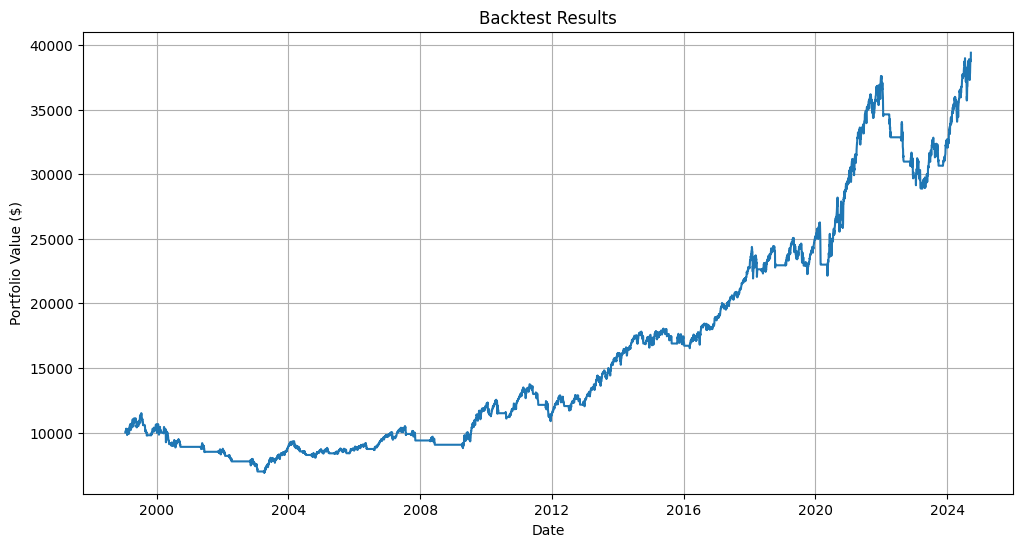

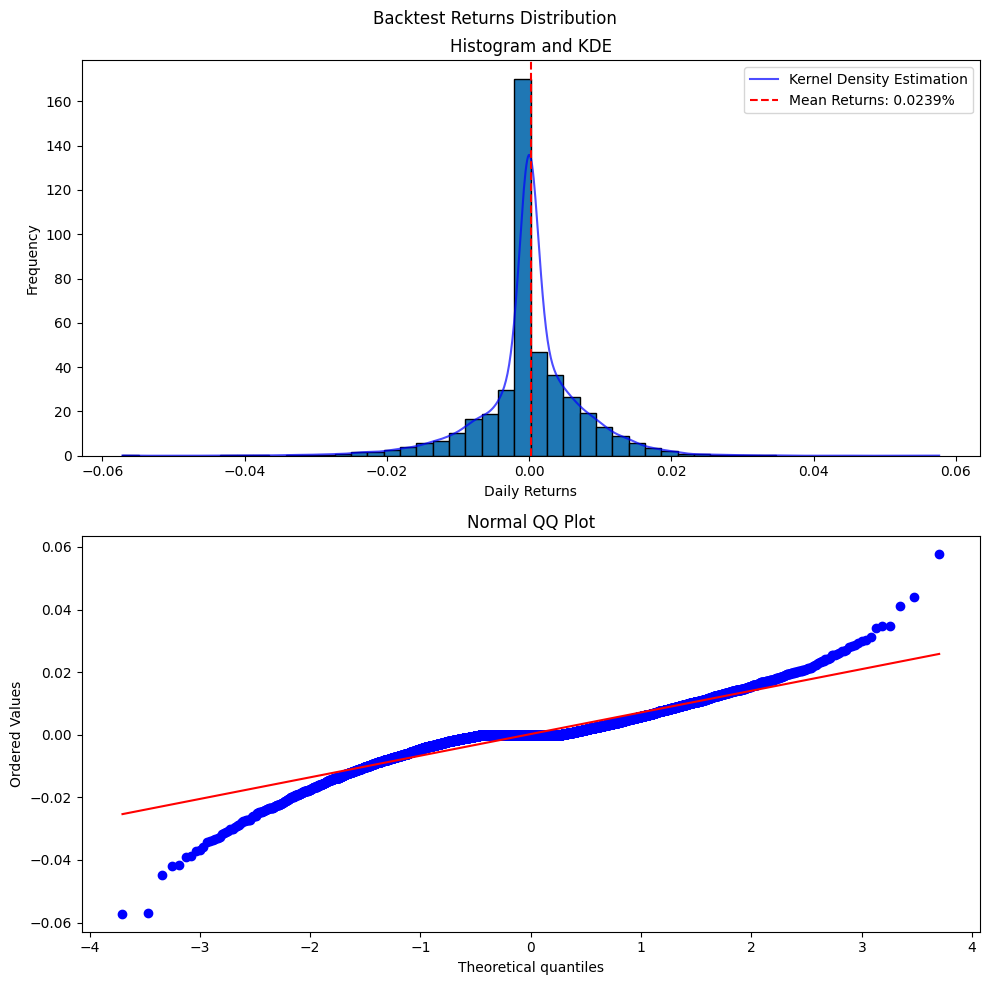

In [8]:
ewmac_trader.plot_results()
ewmac_trader.plot_analysis()

In [9]:
ewmac_short = EWMAC(short_window=SHORT_WINDOW, long_window=LONG_WINDOW, enable_shorting=True)
ewmac_short_trader = BacktestTrader(ewmac_short, prices)

ewmac_short_trader.run_backtest()
ewmac_short_results = ewmac_short_trader.get_results()

In [10]:
print(f'Trading {TICKER} with EWMAC (shorting enabled)')
ewmac_short_results

Trading SPY with EWMAC (shorting enabled)


{'average_returns': 4.701707895193863e-05,
 'annual_returns': 0.011918491239687468,
 'annual_std': 0.16872406132586554,
 'sharpe_ratio': -0.12796600640462194,
 'total_returns': 0.3547028644764043,
 'portfolio_value': 13547.028644764043}

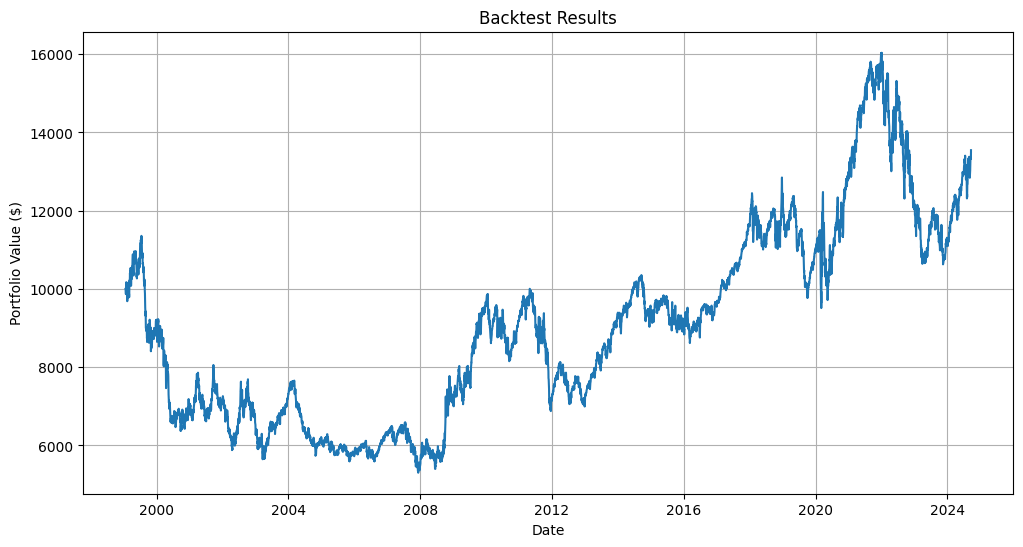

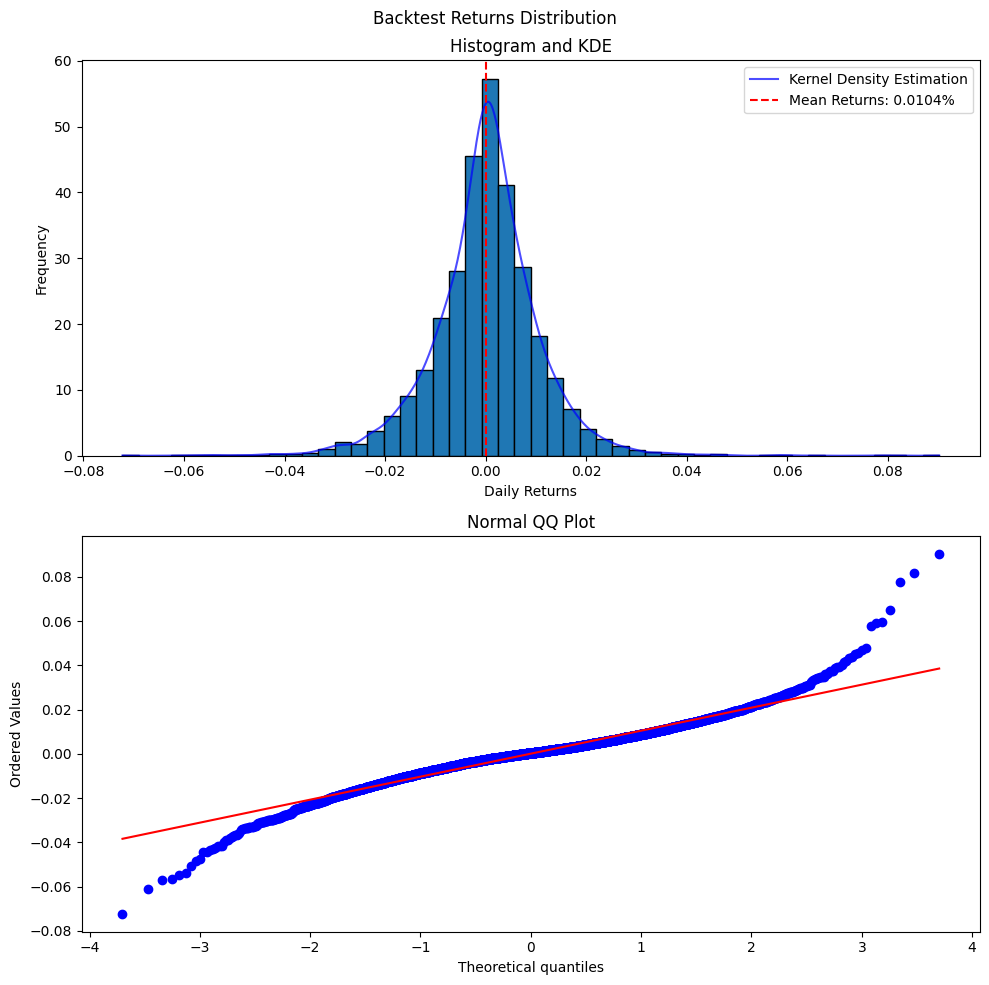

In [11]:
ewmac_short_trader.plot_results()
ewmac_short_trader.plot_analysis(hist_bins=50)

In [12]:
# stationary bootstrap
historical_returns = prices.pct_change().dropna()
data_len = len(historical_returns)
n_iterations = 100
exp_block_len = 16
bootstrap_samples = []

for _ in range(n_iterations):
    sample = []
    i = np.random.randint(0, data_len)
    
    while len(sample) < data_len:
        sample.append(historical_returns.iloc[i])
        
        if np.random.rand() < 1/exp_block_len:
            i = np.random.randint(0, data_len) # sample a new block
        else:
            i = (i+1) % data_len # sample next data point in block
    
    bootstrap_samples.append(np.array(sample))

In [13]:
# reconstruct price time series
initial_price = prices.iloc[0]
bootstrap_prices = []

for sample in bootstrap_samples:
    sample_prices = [initial_price]
    sample_prices.extend(initial_price * (1+sample).cumprod())
    bootstrap_prices.append(sample_prices)

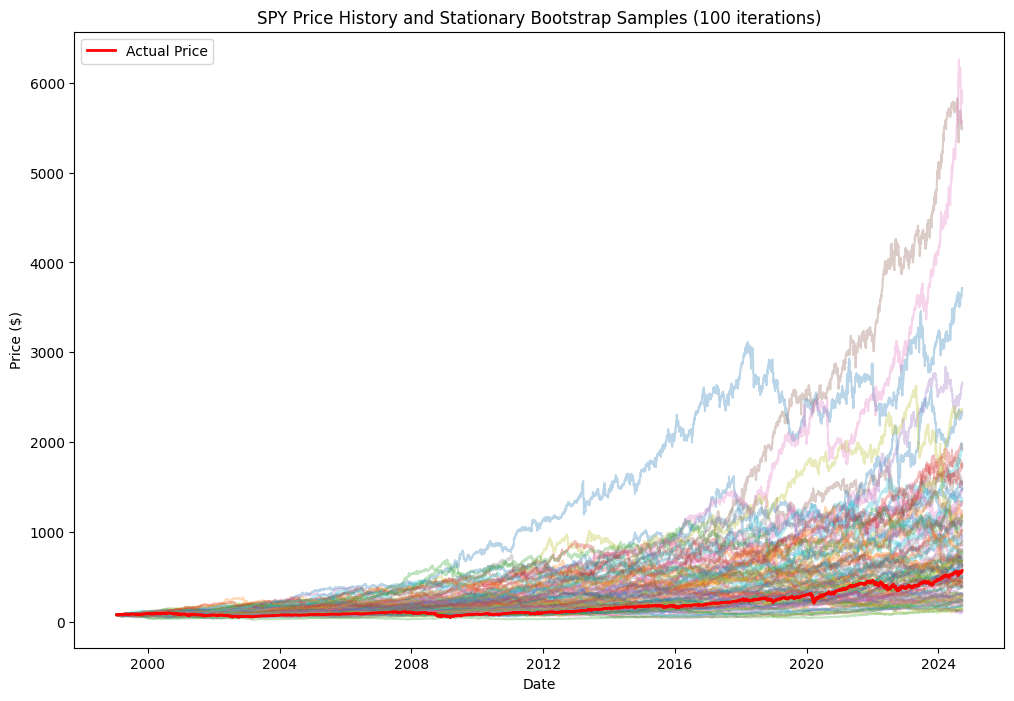

In [14]:
dates = prices.index

# plot
plt.figure(figsize=(12, 8))

for sample in bootstrap_prices:
    plt.plot(dates, sample, alpha=0.3)

plt.plot(prices, label=f'Actual Price', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{TICKER} Price History and Stationary Bootstrap Samples ({n_iterations} iterations)')
plt.legend()
plt.show()

In [15]:
bootstrap_results = ewmac_trader.run_bootstrap(block_size=16)

In [16]:
bootstrap_results

,mean,median,std,95 upper,95 lower
average_returns,0.000168,0.000167,0.000064,0.000291,0.000045
annual_returns,0.043301,0.042987,0.016851,0.076137,0.011385
annual_std,0.152024,0.153232,0.010320,0.168594,0.130041
sharpe_ratio,0.066753,0.061804,0.113915,0.294258,-0.142845


In [17]:
ewmac_results

{'average_returns': 0.0002123889387557476,
 'annual_returns': 0.05497421896492627,
 'annual_std': 0.11592299198520738,
 'sharpe_ratio': 0.1851641598047981,
 'total_returns': 2.9402720279693604,
 'portfolio_value': 39402.7202796936}